# ML challenge: sleep stage detection

## Authors:
- Clément Bonnet
- Nuoya Shao

## Kaggle Challenge Team:
- CBONNET_NSHAO

---

# Challenge description
This challenge is provided by Dreem which aims to develop an algorithm of sleep staging that can differentiate between Wake, N1, N2, N3 and REM on windows of 30 seconds of raw data. The raw data includes 7 EEG channels in frontal and occipital position, 1 pulse oximeter infrared channel, and 3 accelerometer channels (x, y and z).

---

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.signal import butter, lfilter
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import Normalize
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

PATH = ""

# Data description
The data is separated between in different channels recorded by the Dreem headband. Windows of 30 seconds of data are extracted from 61 subject records.

EEG signals are measured at 7 different locations around the head (eeg_1 -> eeg_7). The sampling frequency is 50 Hz.
Pulse oximeter (pulse_oximeter_infrared) and acceleromter (accelerometer_[x/y/z]) channels are sampled at 10Hz
### Main data
- eeg_1 - EEG in frontal position sampled at 50 Hz -> 1500 values\
- eeg_2 - EEG in frontal position sampled at 50 Hz -> 1500 values\
- eeg_3 - EEG in frontal position sampled at 50 Hz -> 1500 values\
- eeg_4 - EEG in frontal-occipital position sampled at 50 Hz -> 1500 values\
- eeg_5 - EEG in frontal-occipital position sampled at 50 Hz -> 1500 values\
- eeg_6 - EEG in frontal-occipital position sampled at 50 Hz -> 1500 values\
- eeg_7 - EEG in frontal-occipital position sampled at 50 Hz -> 1500 values\
- x - Accelerometer along x axis sampled at 10 Hz -> 300 values\
- y - Accelerometer along y axis sampled at 10 Hz -> 300 values\
- z - Accelerometer along z axis sampled at 10 Hz -> 300 values\
- pulse - Pulse oximeter infrared channel sampled at 10 Hz -> 300 values\

### Additionnal meta-data
- index - Subject ID
- index_absolute - correspondance index with y_train, and y_test
- index_window - Index starting at 0 for the first 30-seconds window of a subject then 1 for the following window etc. until the end of the subject's record

### Output Description
The output is a label between 0 and 4
- 0 Wake
- 1 NREM1 Sleep (light sleep 1)
- 2 NREM2 Sleep (light sleep 2)
- 3 NREM3 sleep (deep sleep)
- 4 REM sleep (paradoxical sleep)

### Dataset Dimension

In the train dataset, each signal has a dimension of 24688 x (sampling frequency * 30). E.g: eeg_1 has a dimension of 24688 x 1500 and accelerometer 24688 x 300

In the test dataset, each signal has a dimension of 24980 x (sampling frequency * 30). E.g: eeg_1 has a dimension of 24980 x 1500 and accelerometer 24980 x 300

---

# Data preprocessing

Since the data come from different sensors, there exist two main drawbacks :
* The existence of noise containing useless information which can disturb our prediction
* Different length of data resulting in heterogeneousness

The preprocessing of data becomes important to get a better prediction.
Hence we first create three functions: smooth_filter, upsample and normalize to solve these problems above. 
* smooth_filter is based on butter function, butter is used to design an Nth-order digital or analog Butterworth filter and return the filter coefficients. Here we use a low-pass filter and return a digital filter.
* upsample is based on interp1d which is a method that creates a function based on fixed data points, which can be evaluated anywhere within the domain defined by the given data using linear interpolation. We have extended the data of length 300 to the data of length 1500 without changing the shape of signal.

In [2]:
#This function aims to reduce noise. X is the data with size(24688,1500), for example: egg1 
def smooth_filter(X, cutoff, fs, order=5):
    def butter_lowpass(cutoff, fs, order=5):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a
    b, a = butter_lowpass(cutoff, fs, order=order)
    X_filtered = lfilter(b, a, X)
    return X_filtered

#This function aims to upstream data. X is the data with size(24688,300), for example: pulse 
#And it will return an array with size(24688,1500) 
def upsample(X):
    cX = np.zeros((X.shape[0], 5*X.shape[1]))
    x = np.linspace(0, 5*X.shape[1],X.shape[1])
    xnew = np.linspace(0, 5*X.shape[1],5*X.shape[1])
    for i in range(X.shape[0]):
        y = X[i].copy()
        f = interp1d(x,y,kind='linear')
        cX[i] = f(xnew)
    return cX

def normalize(X):
    return (X-X.mean(axis=-1, keepdims=True))/(X.std(axis=-1, keepdims=True))

def preprocess_channel(X, upsampling=False, filtering=True):
    """
    X is a channel of size (N,300) or (N,1500)
    """
    if upsampling:
        if filtering:
            X_prep = smooth_filter(upsample(X), cutoff=1.5, fs=10, order=5)
        else:
            X_prep = upsample(X)
    else:
        if filtering:
            X_prep = smooth_filter(X, cutoff=5, fs=50, order=5)
        else:
            X_prep = X.copy()
    return normalize(X_prep)

KEYS_FIL = ['eeg_1', 'eeg_2', 'eeg_3', 'eeg_4', 'eeg_5', 'eeg_6', 'eeg_7']
KEYS_UP_FIL = ['pulse']
KEYS_UP = ['x', 'y', 'z']
KEYS = KEYS_FIL + KEYS_UP_FIL + KEYS_UP
def preprocess_dataset(dataset):
    return torch.Tensor([
        preprocess_channel(dataset[key], upsampling=False, filtering=True) if key in KEYS_FIL else
        preprocess_channel(dataset[key], upsampling=True, filtering=True) if key in KEYS_UP_FIL else
        preprocess_channel(dataset[key], upsampling=True, filtering=False) for key in KEYS]).transpose(0,1)

In [3]:
X_train_h5 = h5py.File(PATH + "X_train.h5", "r")
X_test_h5 = h5py.File(PATH + "X_test.h5", "r")
y_train_pd = pd.read_csv(PATH + "y_train.csv")
X_train_h5_prep = preprocess_dataset(X_train_h5)
y_train_h5_prep = torch.LongTensor(y_train_pd["sleep_stage"])
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_h5_prep, y_train_h5_prep, test_size=0.1, random_state=0)
X_test = preprocess_dataset(X_test_h5)
submission = pd.read_csv(PATH + "sample_submission.csv")

### Save datasets

In [4]:
torch.save(X_train_h5_prep, PATH + "data/X_train_h5_prep.pt")
torch.save(y_train_h5_prep, PATH + "data/y_train_h5_prep.pt")
torch.save(X_train, PATH + "data/X_train.pt")
torch.save(X_valid, PATH + "data/X_valid.pt")
torch.save(y_train, PATH + "data/y_train.pt")
torch.save(y_valid, PATH + "data/y_valid.pt")
torch.save(X_test, PATH + "data/X_test.pt")

## Directly load data

In [5]:
X_train_h5 = h5py.File(PATH + "X_train.h5", "r")
X_test_h5 = h5py.File(PATH + "X_test.h5", "r")
y_train_pd = pd.read_csv(PATH + "y_train.csv")
X_train_h5_prep = torch.load(PATH + "data/X_train_h5_prep.pt")
y_train_h5_prep = torch.load(PATH + "data/y_train_h5_prep.pt")
X_train = torch.load(PATH + "data/X_train.pt")
X_valid = torch.load(PATH + "data/X_valid.pt")
y_train = torch.load(PATH + "data/y_train.pt")
y_valid = torch.load(PATH + "data/y_valid.pt")
X_test = torch.load(PATH + "data/X_test.pt")
submission = pd.read_csv(PATH + "sample_submission.csv")

In [7]:
BATCH_SIZE = 64
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
valid_dataset = torch.utils.data.TensorDataset(X_valid, y_valid)
test_dataset = torch.utils.data.TensorDataset(X_test)
full_train_dataset = torch.utils.data.TensorDataset(torch.cat((X_train, X_valid)), torch.cat((y_train, y_valid)))
full_train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

---

# Data visualization

In [8]:
print("Shapes         |    Train set     |    Test set")
print("---------------|------------------|---------------")
for key in X_train_h5.keys():
    print("{:15s}|  {:14s}  |  {:14s}".format(key, str(X_train_h5.get(key).shape), str(X_test_h5.get(key).shape)))

Shapes         |    Train set     |    Test set
---------------|------------------|---------------
eeg_1          |  (24688, 1500)   |  (24980, 1500) 
eeg_2          |  (24688, 1500)   |  (24980, 1500) 
eeg_3          |  (24688, 1500)   |  (24980, 1500) 
eeg_4          |  (24688, 1500)   |  (24980, 1500) 
eeg_5          |  (24688, 1500)   |  (24980, 1500) 
eeg_6          |  (24688, 1500)   |  (24980, 1500) 
eeg_7          |  (24688, 1500)   |  (24980, 1500) 
index          |  (24688,)        |  (24980,)      
index_absolute |  (24688,)        |  (24980,)      
index_window   |  (24688,)        |  (24980,)      
pulse          |  (24688, 300)    |  (24980, 300)  
x              |  (24688, 300)    |  (24980, 300)  
y              |  (24688, 300)    |  (24980, 300)  
z              |  (24688, 300)    |  (24980, 300)  


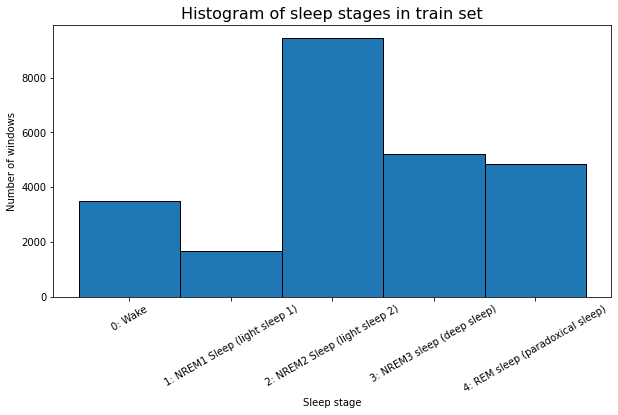

In [9]:
SLEEP_STAGES = {
    0: "Wake",
    1: "NREM1 Sleep (light sleep 1)",
    2: "NREM2 Sleep (light sleep 2)",
    3: "NREM3 sleep (deep sleep)",
    4: "REM sleep (paradoxical sleep)"
}
plt.figure(figsize=(10,5));
plt.hist(y_train_pd["sleep_stage"], bins=np.arange(6)-0.5, edgecolor='black');
plt.xticks(list(SLEEP_STAGES.keys()), [str(i)+": "+sleep_stage for i, sleep_stage in SLEEP_STAGES.items()], rotation=30);
plt.xlabel("Sleep stage");
plt.ylabel("Number of windows");
plt.title("Histogram of sleep stages in train set", fontsize=16);

Subject ID: 2
Subject's window number: 944
Window ID: 2732
Sleep stage: 2


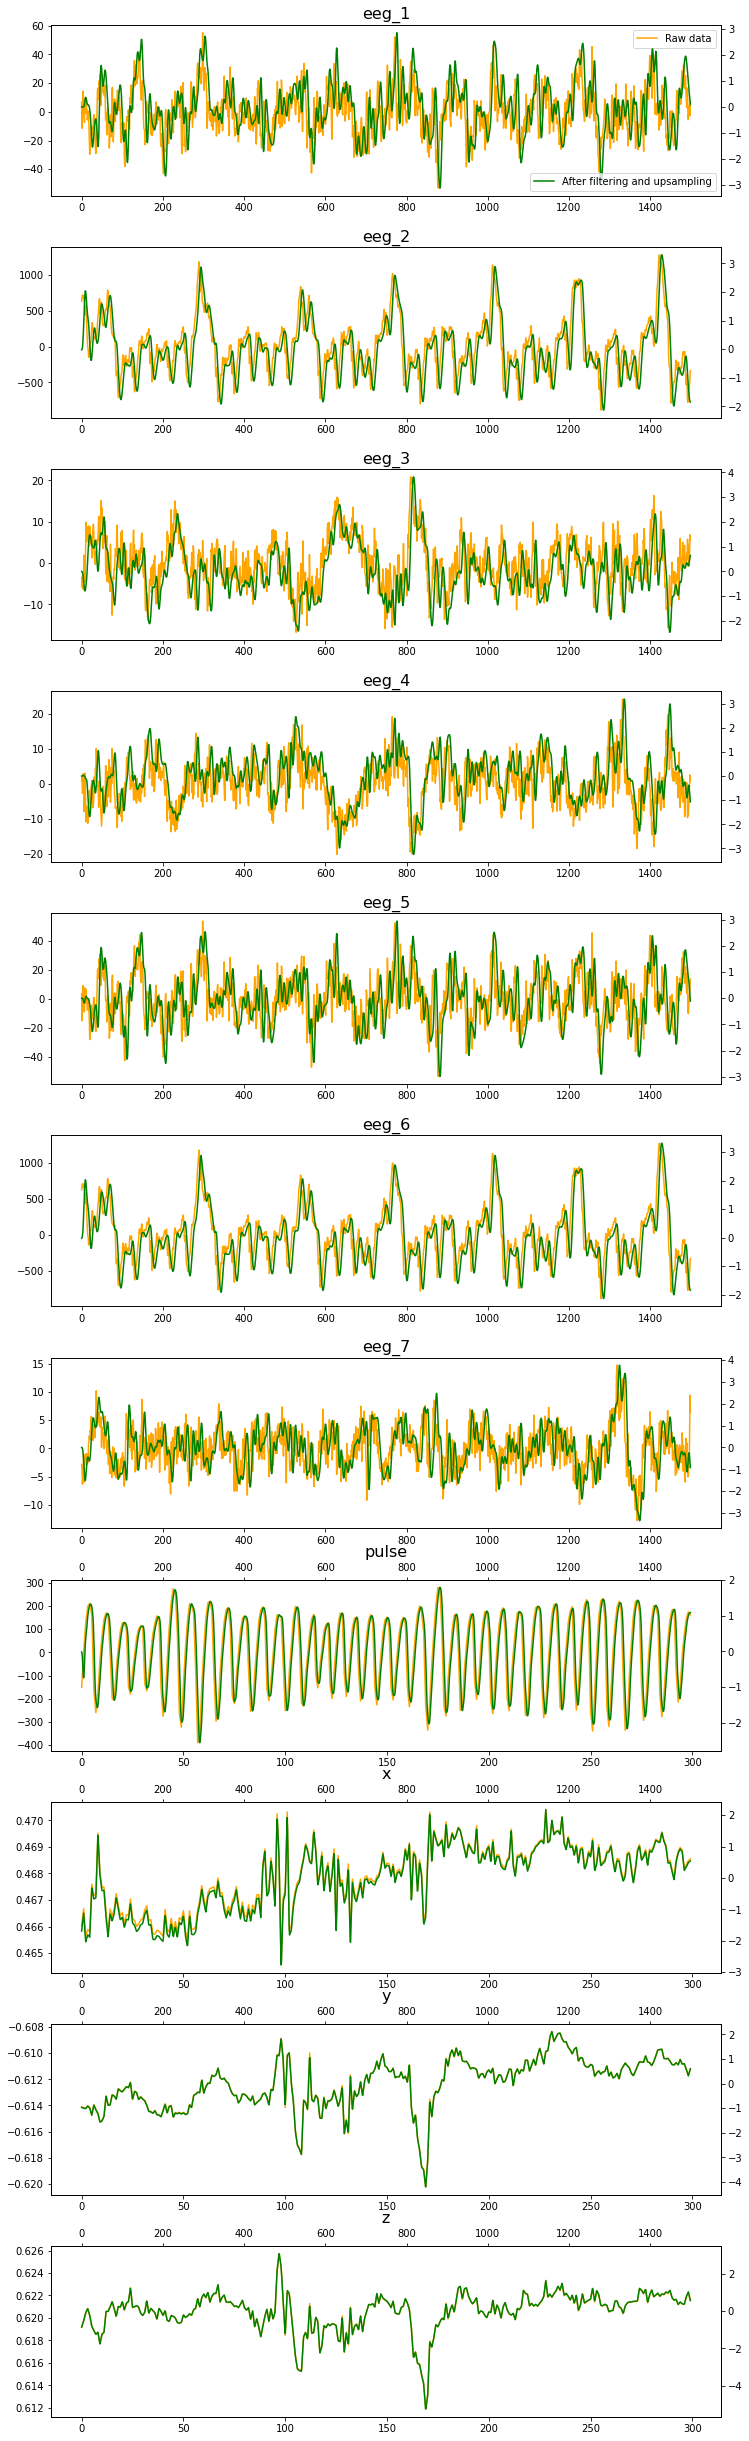

In [24]:
np.random.seed(0)
window_id = np.random.randint(0, X_train_h5_prep.shape[0]-1)
print("Subject ID:", X_train_h5["index"][window_id])
print("Subject's window number:", X_train_h5["index_window"][window_id])
print("Window ID:", X_train_h5["index_absolute"][window_id])
print("Sleep stage:", y_train_pd.loc[window_id, "sleep_stage"])
plt.figure(figsize=(12, 4*len(KEYS)));
for i, key in enumerate(KEYS):
    plt.subplot(len(KEYS), 1, i+1);
    plt.subplots_adjust(hspace=0.3);
    plt.plot(X_train_h5[key][window_id], c="orange", label="Raw data");
    if i==0: plt.legend(loc="upper right");
    plt.twinx();
    if key in KEYS_UP_FIL + KEYS_UP:
        plt.twiny();
    plt.plot(X_train_h5_prep[window_id][i], c="green", label="After filtering and upsampling");
    if i==0: plt.legend(loc="lower right");
    plt.title(key, fontsize=16);

We can see from the result that the noise has been significantly reduced, therefore it can improve our future predictions for different stages by cleaning the useless information. 

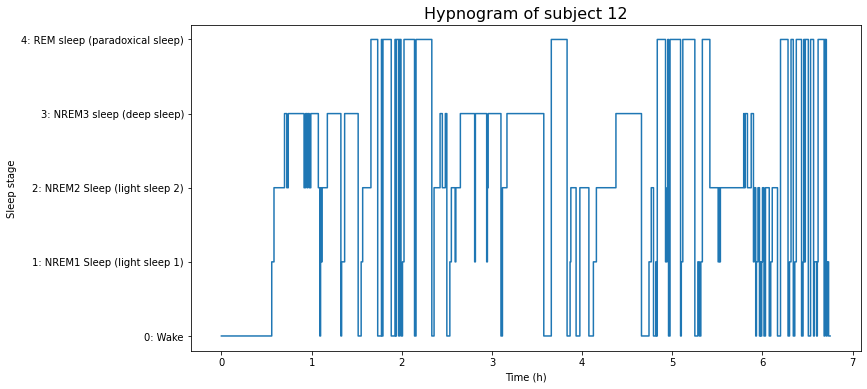

In [11]:
np.random.seed(0)
subject_id = np.random.randint(max(X_train_h5["index"]))

hypnogram = [y_train_pd.loc[window_id, "sleep_stage"]
             for window_id, subject_index in enumerate(X_train_h5["index"])
             if subject_index == subject_id]

plt.figure(figsize=(12,6));
plt.step(30/3600 * np.arange(len(hypnogram)), hypnogram);
plt.xlabel("Time (h)");
plt.ylabel("Sleep stage");
plt.yticks(list(SLEEP_STAGES.keys()), [str(i)+": "+sleep_stage for i, sleep_stage in SLEEP_STAGES.items()]);
plt.title("Hypnogram of subject {}".format(subject_id), fontsize=16);

One can see that sleep stages can highly vary within a night.

---

# Models

In [12]:
class StagerNet2(nn.Module):
    def __init__(self, C=11):
        super(StagerNet2, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=C, kernel_size=(C,1))
        self.conv_2 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(1,20))
        self.batch_norm_1 = nn.BatchNorm2d(64)
        self.max_pool_1 = nn.MaxPool2d(kernel_size=(1,4))
        self.conv_3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1,20))
        self.batch_norm_2 = nn.BatchNorm2d(128)
        self.max_pool_2 = nn.MaxPool2d(kernel_size=(1,4))
        self.flatten = nn.Flatten()
        self.linear_1 = nn.Linear(in_features=C*128*87, out_features=100)
        self.dropout = nn.Dropout(p=0.4)
        self.linear_2 = nn.Linear(in_features=100, out_features=5)
        self.softmax = nn.Softmax(dim=-1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv_1(x).transpose(2,1)
        x = self.conv_2(x)
        x = self.batch_norm_1(x)
        x = self.max_pool_1(x)
        x = self.relu(x)
        x = self.conv_3(x)
        x = self.batch_norm_2(x)
        x = self.max_pool_2(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.linear_1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.linear_2(x)
        x = self.softmax(x)
        return x

    def classify(self, x):
        x = self(x)
        return torch.argmax(x, 1)


In [13]:
class OneDCNN(nn.Module):
    """https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6406978/table/ijerph-16-00599-t002/"""
    def __init__(self, C=11):
        super(OneDCNN, self).__init__()
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.conv_1 = nn.Conv1d(
            in_channels=C, out_channels=64, kernel_size=5, stride=3)
        self.conv_2 = nn.Conv1d(
            in_channels=64, out_channels=128, kernel_size=5, stride=1)
        self.max_pool_3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout_4 = nn.Dropout(p=0.2)
        self.conv_5 = nn.Conv1d(
            in_channels=128, out_channels=128, kernel_size=13, stride=1)
        self.conv_6 = nn.Conv1d(
            in_channels=128, out_channels=256, kernel_size=7, stride=1)
        self.max_pool_7 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv_8 = nn.Conv1d(
            in_channels=256, out_channels=256, kernel_size=7, stride=1)
        self.conv_9 = nn.Conv1d(
            in_channels=256, out_channels=64, kernel_size=7, stride=1)
        self.max_pool_10 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv_11 = nn.Conv1d(
            in_channels=64, out_channels=32, kernel_size=3, stride=1)
        self.conv_12 = nn.Conv1d(
            in_channels=32, out_channels=64, kernel_size=6, stride=1)
        self.max_pool_13 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv_14 = nn.Conv1d(
            in_channels=64, out_channels=8, kernel_size=5, stride=1)
        self.conv_15 = nn.Conv1d(
            in_channels=8, out_channels=8, kernel_size=2, stride=1)
        self.max_pool_16 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dense_18 = nn.Linear(in_features=64, out_features=64)
        self.dropout_18 = nn.Dropout(p=0.2)
        self.dense_19 = nn.Linear(in_features=64, out_features=5)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        x = self.max_pool_3(x)
        x = self.dropout_4(x)
        x = self.relu(self.conv_5(x))
        x = self.relu(self.conv_6(x))
        x = self.max_pool_7(x)
        x = self.relu(self.conv_8(x))
        x = self.relu(self.conv_9(x))
        x = self.max_pool_10(x)
        x = self.relu(self.conv_11(x))
        x = self.relu(self.conv_12(x))
        x = self.max_pool_13(x)
        x = self.relu(self.conv_14(x))
        x = self.relu(self.conv_15(x))
        x = self.max_pool_16(x)
        x = self.flatten(x)
        x = self.dropout_18(self.relu(self.dense_18(x)))
        x = self.dense_19(x)
        x = self.softmax(x)
        return x
    
    def classify(self, x):
        x = self(x)
        return torch.argmax(x, 1)

In [14]:
class OneDCNN2(nn.Module):
    """https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6406978/table/ijerph-16-00599-t002/"""
    def __init__(self, C=11):
        super(OneDCNN2, self).__init__()
        self.relu = nn.ReLU()
        self.conv_1 = nn.Conv1d(
            in_channels=C, out_channels=64, kernel_size=5, stride=3)
        self.conv_2 = nn.Conv1d(
            in_channels=64, out_channels=128, kernel_size=5, stride=1)
        self.max_pool_3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout_4 = nn.Dropout(p=0.2)
        self.conv_5 = nn.Conv1d(
            in_channels=128, out_channels=128, kernel_size=13, stride=1)
        self.conv_6 = nn.Conv1d(
            in_channels=128, out_channels=256, kernel_size=7, stride=1)
        self.max_pool_7 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv_8 = nn.Conv1d(
            in_channels=256, out_channels=256, kernel_size=7, stride=1)
        self.conv_9 = nn.Conv1d(
            in_channels=256, out_channels=64, kernel_size=7, stride=1)
        self.max_pool_10 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv_11 = nn.Conv1d(
            in_channels=64, out_channels=32, kernel_size=3, stride=1)
        self.conv_12 = nn.Conv1d(
            in_channels=32, out_channels=64, kernel_size=6, stride=1)
        self.max_pool_13 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv_14 = nn.Conv1d(
            in_channels=64, out_channels=16, kernel_size=5, stride=1)
        self.conv_15 = nn.Conv1d(
            in_channels=16, out_channels=16, kernel_size=2, stride=1)
        self.flatten_17 = nn.Flatten()
        self.dense_18 = nn.Linear(in_features=272, out_features=256)
        self.dropout_18 = nn.Dropout(p=0.2)
        self.dense_19 = nn.Linear(in_features=256, out_features=5)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        x = self.max_pool_3(x)
        x = self.dropout_4(x)
        x = self.relu(self.conv_5(x))
        x = self.relu(self.conv_6(x))
        x = self.max_pool_7(x)
        x = self.relu(self.conv_8(x))
        x = self.relu(self.conv_9(x))
        x = self.max_pool_10(x)
        x = self.relu(self.conv_11(x))
        x = self.relu(self.conv_12(x))
        x = self.max_pool_13(x)
        x = self.relu(self.conv_14(x))
        x = self.relu(self.conv_15(x))
        x = self.flatten_17(x)
        x = self.dropout_18(self.relu(self.dense_18(x)))
        x = self.dense_19(x)
        x = self.softmax(x)
        return x
    
    def classify(self, x):
        x = self(x)
        return torch.argmax(x, 1)

In [15]:
for parameter in OneDCNN2().parameters():
    print(parameter.numel())

3520
64
40960
128
212992
128
229376
256
458752
256
114688
64
6144
32
12288
64
5120
16
512
16
69632
256
1280
5


In [16]:
print("Number of parameters StagerNet2: {:,}".format(sum([parameter.numel() for parameter in StagerNet2().parameters()])))
print("Number of parameters OneDCNN:    {:,}".format(sum([parameter.numel() for parameter in OneDCNN().parameters()])))
print("Number of parameters OneDCNN2:    {:,}".format(sum([parameter.numel() for parameter in OneDCNN2().parameters()])))

Number of parameters StagerNet2: 12,416,033
Number of parameters OneDCNN:    1,086,901
Number of parameters OneDCNN2:    1,156,549


---

# Training

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [17]:
def plot_curves(train_loss, valid_loss, train_f1_score, valid_f1_score, print_epochs=1, N=10):
    # N: running mean, print_epochs: number of epochs in between each point
    plt.plot(
        np.arange(print_epochs, print_epochs*(len(train_loss)+1), print_epochs),
        train_loss, c="blue", alpha=1, label="Training loss");
    plt.plot(
        np.arange(print_epochs, print_epochs*(len(valid_loss)+1), print_epochs),
        valid_loss, c="brown", alpha=1, label="Validation loss");
    plt.ylabel("Loss");
    plt.xlabel("Epochs");
    plt.legend();
    plt.twinx();
    plt.plot(
        np.arange(print_epochs, print_epochs*(len(valid_f1_score)+1), print_epochs),
        valid_f1_score, c="orange", alpha=1, label="Validation f1 score");
    plt.plot(
        np.arange(print_epochs, print_epochs*(len(train_f1_score)+1), print_epochs),
        train_f1_score, c="green", alpha=1, label="Training f1 score");
    plt.legend();
    plt.ylabel("F1 score");
    plt.tight_layout();

---

In [ ]:
torch.manual_seed(0)
cla = OneDCNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(cla.parameters(), lr=0.00001)
EPOCHS = 400
PRINT_EPOCHS = 10

In [ ]:
train_loss, valid_loss, valid_f1_score, train_f1_score = [], [], [], []
cla.train()
epoch_train_loss = 0
for epoch in range(EPOCHS):
    for i, data in enumerate(train_loader):
        inputs = data[0].to(device)
        labels = data[1].to(device)
        optimizer.zero_grad()
        outputs = cla(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    if epoch%PRINT_EPOCHS == PRINT_EPOCHS-1:
        cla.eval()
        epoch_valid_loss = loss_fn(cla(X_valid.to(device)), y_valid.to(device)).item()
        valid_predict = cla.classify(X_valid.to(device))
        train_indices = np.random.choice(range(len(X_train)), size=20*BATCH_SIZE, replace=False)
        train_predict = cla.classify(X_train[train_indices].to(device))
        valid_f1 = f1_score(y_valid, valid_predict.cpu(), average="micro")
        train_f1 = f1_score(y_train[train_indices], train_predict.cpu(), average="micro")
        epoch_train_loss = epoch_train_loss/(len(train_loader)*PRINT_EPOCHS)
        print("[epoch {:2d}]  train_loss: {:.3f}  valid_loss: {:.3f}  train_f1_score: {:.3f}  valid_f1_score: {:.3f}".format(
            epoch+1, epoch_train_loss, epoch_valid_loss, train_f1, valid_f1))
        train_loss.append(epoch_train_loss)
        valid_loss.append(epoch_valid_loss)
        valid_f1_score.append(valid_f1)
        train_f1_score.append(train_f1)
        epoch_train_loss = 0
        cla.train()
cla = cla.eval()

[epoch 10]  train_loss: 1.523  valid_loss: 1.519  train_f1_score: 0.404  valid_f1_score: 0.379
[epoch 20]  train_loss: 1.497  valid_loss: 1.503  train_f1_score: 0.412  valid_f1_score: 0.387
[epoch 30]  train_loss: 1.470  valid_loss: 1.472  train_f1_score: 0.442  valid_f1_score: 0.418
[epoch 40]  train_loss: 1.452  valid_loss: 1.459  train_f1_score: 0.424  valid_f1_score: 0.424
[epoch 50]  train_loss: 1.429  valid_loss: 1.426  train_f1_score: 0.484  valid_f1_score: 0.470
[epoch 60]  train_loss: 1.399  valid_loss: 1.397  train_f1_score: 0.532  valid_f1_score: 0.501
[epoch 70]  train_loss: 1.383  valid_loss: 1.386  train_f1_score: 0.531  valid_f1_score: 0.513
[epoch 80]  train_loss: 1.372  valid_loss: 1.378  train_f1_score: 0.527  valid_f1_score: 0.520
[epoch 90]  train_loss: 1.364  valid_loss: 1.372  train_f1_score: 0.553  valid_f1_score: 0.528
[epoch 100]  train_loss: 1.359  valid_loss: 1.367  train_f1_score: 0.545  valid_f1_score: 0.533
[epoch 110]  train_loss: 1.354  valid_loss: 1.365

In [ ]:
cla.train()
epoch_train_loss = 0
for epoch in range(400, 400 + 200):
    for i, data in enumerate(train_loader):
        inputs = data[0].to(device)
        labels = data[1].to(device)
        optimizer.zero_grad()
        outputs = cla(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    if epoch%PRINT_EPOCHS == PRINT_EPOCHS-1:
        cla.eval()
        epoch_valid_loss = loss_fn(cla(X_valid.to(device)), y_valid.to(device)).item()
        valid_predict = cla.classify(X_valid.to(device))
        train_indices = np.random.choice(range(len(X_train)), size=20*BATCH_SIZE, replace=False)
        train_predict = cla.classify(X_train[train_indices].to(device))
        valid_f1 = f1_score(y_valid, valid_predict.cpu(), average="micro")
        train_f1 = f1_score(y_train[train_indices], train_predict.cpu(), average="micro")
        epoch_train_loss = epoch_train_loss/(len(train_loader)*PRINT_EPOCHS)
        print("[epoch {:2d}]  train_loss: {:.3f}  valid_loss: {:.3f}  train_f1_score: {:.3f}  valid_f1_score: {:.3f}".format(
            epoch+1, epoch_train_loss, epoch_valid_loss, train_f1, valid_f1))
        train_loss.append(epoch_train_loss)
        valid_loss.append(epoch_valid_loss)
        valid_f1_score.append(valid_f1)
        train_f1_score.append(train_f1)
        epoch_train_loss = 0
        cla.train()
cla = cla.eval()

[epoch 410]  train_loss: 1.214  valid_loss: 1.249  train_f1_score: 0.676  valid_f1_score: 0.652
[epoch 420]  train_loss: 1.210  valid_loss: 1.246  train_f1_score: 0.713  valid_f1_score: 0.657
[epoch 430]  train_loss: 1.206  valid_loss: 1.237  train_f1_score: 0.721  valid_f1_score: 0.663
[epoch 440]  train_loss: 1.204  valid_loss: 1.240  train_f1_score: 0.723  valid_f1_score: 0.659
[epoch 450]  train_loss: 1.203  valid_loss: 1.249  train_f1_score: 0.689  valid_f1_score: 0.651
[epoch 460]  train_loss: 1.200  valid_loss: 1.245  train_f1_score: 0.699  valid_f1_score: 0.653
[epoch 470]  train_loss: 1.198  valid_loss: 1.229  train_f1_score: 0.705  valid_f1_score: 0.672
[epoch 480]  train_loss: 1.195  valid_loss: 1.236  train_f1_score: 0.731  valid_f1_score: 0.664
[epoch 490]  train_loss: 1.193  valid_loss: 1.235  train_f1_score: 0.716  valid_f1_score: 0.663
[epoch 500]  train_loss: 1.192  valid_loss: 1.256  train_f1_score: 0.695  valid_f1_score: 0.645
[epoch 510]  train_loss: 1.190  valid_lo

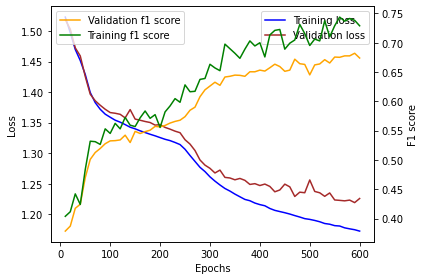

In [ ]:
plot_curves(train_loss, valid_loss, train_f1_score, valid_f1_score, print_epochs=PRINT_EPOCHS)

We draw the validation score, validation loss, training score and training loss together to observe our model's performance.
Apparently, both score continu growning and both loss are declining. Finaly, the validation f1 score reachs around 67%, it won't augment anymore even with more epochs.

Besides, the training f1 score reachs around 73% which is higher than validation score indicating there may be the overfitting. 

In [ ]:
torch.manual_seed(0)
cla = cla.train().to(device)
optimizer = optim.Adam(cla.parameters(), lr=0.00001)
epoch_train_loss = 0
for epoch in range(600, 600 + 200):
    for i, data in enumerate(train_loader):
        inputs = data[0].to(device)
        labels = data[1].to(device)
        optimizer.zero_grad()
        outputs = cla(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    if epoch%PRINT_EPOCHS == PRINT_EPOCHS-1:
        cla.eval()
        epoch_valid_loss = loss_fn(cla(X_valid.to(device)), y_valid.to(device)).item()
        valid_predict = cla.classify(X_valid.to(device))
        train_indices = np.random.choice(range(len(X_train)), size=20*BATCH_SIZE, replace=False)
        train_predict = cla.classify(X_train[train_indices].to(device))
        valid_f1 = f1_score(y_valid, valid_predict.cpu(), average="micro")
        train_f1 = f1_score(y_train[train_indices], train_predict.cpu(), average="micro")
        epoch_train_loss = epoch_train_loss/(len(train_loader)*PRINT_EPOCHS)
        print("[epoch {:2d}]  train_loss: {:.3f}  valid_loss: {:.3f}  train_f1_score: {:.3f}  valid_f1_score: {:.3f}".format(
            epoch+1, epoch_train_loss, epoch_valid_loss, train_f1, valid_f1))
        train_loss.append(epoch_train_loss)
        valid_loss.append(epoch_valid_loss)
        valid_f1_score.append(valid_f1)
        train_f1_score.append(train_f1)
        epoch_train_loss = 0
        cla.train()
cla = cla.eval()

[epoch 610]  train_loss: 1.170  valid_loss: 1.222  train_f1_score: 0.749  valid_f1_score: 0.680
[epoch 620]  train_loss: 1.169  valid_loss: 1.218  train_f1_score: 0.747  valid_f1_score: 0.684
[epoch 630]  train_loss: 1.166  valid_loss: 1.220  train_f1_score: 0.750  valid_f1_score: 0.682
[epoch 640]  train_loss: 1.165  valid_loss: 1.224  train_f1_score: 0.733  valid_f1_score: 0.677
[epoch 650]  train_loss: 1.164  valid_loss: 1.220  train_f1_score: 0.772  valid_f1_score: 0.680
[epoch 660]  train_loss: 1.161  valid_loss: 1.214  train_f1_score: 0.761  valid_f1_score: 0.686
[epoch 670]  train_loss: 1.160  valid_loss: 1.215  train_f1_score: 0.759  valid_f1_score: 0.686
[epoch 680]  train_loss: 1.157  valid_loss: 1.216  train_f1_score: 0.761  valid_f1_score: 0.684
[epoch 690]  train_loss: 1.155  valid_loss: 1.216  train_f1_score: 0.752  valid_f1_score: 0.684
[epoch 700]  train_loss: 1.153  valid_loss: 1.216  train_f1_score: 0.765  valid_f1_score: 0.682
[epoch 710]  train_loss: 1.152  valid_lo

We see clearly that training f1 score climbs a little bit but validation f1 score does not augment anymore.

---

In [ ]:
torch.manual_seed(0)
cla = OneDCNN2().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(cla.parameters(), lr=0.00005)
EPOCHS = 500
PRINT_EPOCHS = 10

In [ ]:
train_loss, valid_loss, valid_f1_score, train_f1_score = [], [], [], []
cla.train()
epoch_train_loss = 0
for epoch in range(EPOCHS):
    for i, data in enumerate(train_loader):
        inputs = data[0].to(device)
        labels = data[1].to(device)
        optimizer.zero_grad()
        outputs = cla(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    if epoch%PRINT_EPOCHS == PRINT_EPOCHS-1:
        cla.eval()
        epoch_valid_loss = loss_fn(cla(X_valid.to(device)), y_valid.to(device)).item()
        valid_predict = cla.classify(X_valid.to(device))
        train_indices = np.random.choice(range(len(X_train)), size=20*BATCH_SIZE, replace=False)
        train_predict = cla.classify(X_train[train_indices].to(device))
        valid_f1 = f1_score(y_valid, valid_predict.cpu(), average="micro")
        train_f1 = f1_score(y_train[train_indices], train_predict.cpu(), average="micro")
        epoch_train_loss = epoch_train_loss/(len(train_loader)*PRINT_EPOCHS)
        print("[epoch {:2d}]  train_loss: {:.3f}  valid_loss: {:.3f}  train_f1_score: {:.3f}  valid_f1_score: {:.3f}".format(
            epoch+1, epoch_train_loss, epoch_valid_loss, train_f1, valid_f1))
        train_loss.append(epoch_train_loss)
        valid_loss.append(epoch_valid_loss)
        valid_f1_score.append(valid_f1)
        train_f1_score.append(train_f1)
        epoch_train_loss = 0
        cla.train()
cla = cla.eval()

[epoch 10]  train_loss: 1.466  valid_loss: 1.462  train_f1_score: 0.438  valid_f1_score: 0.425
[epoch 20]  train_loss: 1.344  valid_loss: 1.330  train_f1_score: 0.583  valid_f1_score: 0.571
[epoch 30]  train_loss: 1.254  valid_loss: 1.258  train_f1_score: 0.670  valid_f1_score: 0.640
[epoch 40]  train_loss: 1.226  valid_loss: 1.253  train_f1_score: 0.710  valid_f1_score: 0.647
[epoch 50]  train_loss: 1.203  valid_loss: 1.251  train_f1_score: 0.695  valid_f1_score: 0.651
[epoch 60]  train_loss: 1.189  valid_loss: 1.271  train_f1_score: 0.680  valid_f1_score: 0.625
[epoch 70]  train_loss: 1.171  valid_loss: 1.241  train_f1_score: 0.745  valid_f1_score: 0.659
[epoch 80]  train_loss: 1.155  valid_loss: 1.232  train_f1_score: 0.764  valid_f1_score: 0.669
[epoch 90]  train_loss: 1.150  valid_loss: 1.250  train_f1_score: 0.732  valid_f1_score: 0.651
[epoch 100]  train_loss: 1.135  valid_loss: 1.216  train_f1_score: 0.785  valid_f1_score: 0.688
[epoch 110]  train_loss: 1.119  valid_loss: 1.217

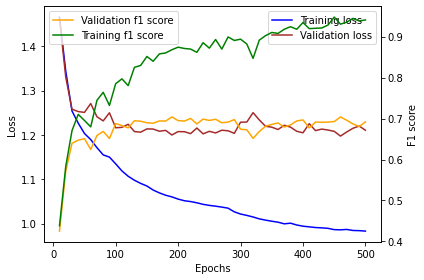

In [ ]:
plot_curves(train_loss, valid_loss, train_f1_score, valid_f1_score, print_epochs=PRINT_EPOCHS)

Compared to OneDCNN model, OneDCNN2 get a much better score around 95% for training data which is quite accurate.

On the contrary, the validation score stay around 70%. There is no significant improvement compared with OneDCNN model for the final score and may also have the problem of overfitting. 

However, OneDCNN2 converge much faster than OneDCNN. Within 200 epochs, OneDCNN2 already reach 70% but it takes OneDCNN 600 epochs to get the same score. 

---

## Save model

In [ ]:
torch.save(cla.state_dict(), PATH + "OneDCNN2_500.pt")

In [ ]:
print(classification_report(cla.to("cuda").classify(X_valid.to("cuda")).cpu().numpy(), y_valid.numpy()))

              precision    recall  f1-score   support

           0       0.70      0.68      0.69       378
           1       0.19      0.19      0.19       183
           2       0.72      0.76      0.74       853
           3       0.83      0.82      0.82       526
           4       0.68      0.64      0.66       529

    accuracy                           0.69      2469
   macro avg       0.62      0.62      0.62      2469
weighted avg       0.69      0.69      0.69      2469



# Submission

#### Test set visualization

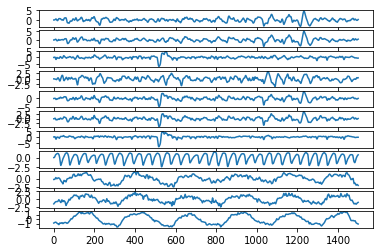

In [ ]:
for i in range(11):
    plt.subplot(11,1,i+1);
    plt.plot(X_test[100][i]);

#### Load trained model

In [ ]:
cla = OneDCNN2()
cla.load_state_dict(torch.load(PATH + "OneDCNN2_500.pt"))
cla.eval()

OneDCNN(
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv_1): Conv1d(11, 64, kernel_size=(5,), stride=(3,))
  (conv_2): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
  (max_pool_3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout_4): Dropout(p=0.2, inplace=False)
  (conv_5): Conv1d(128, 128, kernel_size=(13,), stride=(1,))
  (conv_6): Conv1d(128, 256, kernel_size=(7,), stride=(1,))
  (max_pool_7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_8): Conv1d(256, 256, kernel_size=(7,), stride=(1,))
  (conv_9): Conv1d(256, 64, kernel_size=(7,), stride=(1,))
  (max_pool_10): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_11): Conv1d(64, 32, kernel_size=(3,), stride=(1,))
  (conv_12): Conv1d(32, 64, kernel_size=(6,), stride=(1,))
  (max_pool_13): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_14): Conv1d(64, 8, kernel_size=(5,

In [ ]:
submission

,index,sleep_stage
0,24688,0
1,24689,0
2,24690,0
3,24691,0
4,24692,0
...,...,...
24975,49663,2
24976,49664,4
24977,49665,4
24978,49666,4


#### Model predictions on test set

In [ ]:
submission["sleep_stage"] = -1
for i in range(249):
    submission.loc[100*i:100*(i+1)-1, "sleep_stage"] = cla.classify(X_test[100*i:100*(i+1)]).numpy()
submission.loc[24900:, "sleep_stage"] = cla.classify(X_test[24900:]).numpy()

In [ ]:
submission

,index,sleep_stage
0,24688,0
1,24689,0
2,24690,0
3,24691,0
4,24692,0
...,...,...
24975,49663,4
24976,49664,1
24977,49665,4
24978,49666,4


In [ ]:
submission.to_csv(PATH + "to_submit.csv", index=False)